## Imports


In [70]:
import warnings
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
import polars as pl
import optuna
import polars.selectors as cs
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
from optuna import Study, create_study
from optuna.pruners import SuccessiveHalvingPruner
from optuna.samplers import RandomSampler
from optuna.trial._frozen import FrozenTrial
from pandas import DataFrame, Series
from polars import DataFrame
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from polars.dataframe.frame import DataFrame
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier
from polars.series.series import Series
import scipy.stats as stats
from numpy.typing import NDArray
from optuna.study.study import Study


warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)
pio.templates.default = "plotly_dark"


# set trials globally to optimize run time
num_trials = 15

### Loan_functions.py

In [2]:
from loan_functions import (
    create_formatted_df,
    lower_column_names,
    lower_column_values,
    plot_histogram,
    null_count_comparison,
    objective,
    calculate_model_statistics,
    instantiate_model,
    create_encoder_mapping,
    encode_feature,
    replicate_classifier_tuning,
)

Let's begin by exploring the the training set. 

### Data Exploration


Let's start by reading in the training set and looking at balance. I'll keep the EDA of this notebook focused on the training set to have a more focused analysis and discussion of modeling and model performance, but a more detailed exploration of the supporting datasets can be found in the [notebook] found in this repository.

In [3]:
application_train = create_formatted_df("application_train.csv")

print(
    f"Training set has {application_train.shape[0]} rows and {application_train.shape[1]} columns."
)

application_train.sample(5)

Training set has 307511 rows and 122 columns.


sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,…,nonlivingarea_medi,fondkapremont_mode,housetype_mode,totalarea_mode,wallsmaterial_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
i64,i64,str,str,str,str,i64,f64,f64,f64,f64,str,str,str,str,str,f64,i64,i64,f64,i64,f64,i64,i64,i64,i64,i64,i64,str,f64,i64,i64,str,i64,i64,i64,i64,…,f64,str,str,f64,str,str,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64
176926,0,"""cash loans""","""f""","""n""","""y""",0,135000.0,337500.0,24687.0,337500.0,"""unaccompanied""","""working""","""secondary / secondary special""","""married""","""house / apartment""",0.015221,-19486,-587,-9985.0,-3012,null,1,1,0,1,0,0,null,2.0,2,2,"""saturday""",9,0,0,0,…,0.0,"""reg oper account""","""block of flats""",0.0477,"""stone, brick""","""no""",1.0,0.0,1.0,0.0,-2023.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
341846,0,"""cash loans""","""f""","""n""","""n""",1,85500.0,454500.0,14791.5,454500.0,"""unaccompanied""","""working""","""lower secondary""","""civil marriage""","""house / apartment""",0.0228,-12506,-3243,-4909.0,-4971,null,1,1,0,1,1,0,null,3.0,2,2,"""thursday""",9,0,0,0,…,0.0175,null,"""block of flats""",0.0112,"""stone, brick""","""no""",1.0,0.0,1.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
115647,0,"""cash loans""","""f""","""n""","""y""",0,202500.0,495000.0,36355.5,495000.0,"""unaccompanied""","""commercial associate""","""secondary / secondary special""","""married""","""house / apartment""",0.018209,-11066,-1676,-3836.0,-1680,null,1,1,0,1,1,0,"""core staff""",2.0,3,3,"""monday""",8,0,0,0,…,0.0,null,"""terraced house""",0.0021,"""block""","""no""",2.0,0.0,2.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,null,null,null,null,null,null
454433,1,"""cash loans""","""f""","""n""","""y""",1,144000.0,284400.0,18643.5,225000.0,"""family""","""working""","""secondary / secondary special""","""married""","""house / apartment""",0.00823,-10185,-3276,-4285.0,-776,null,1,1,0,1,0,0,"""sales staff""",3.0,2,2,"""thursday""",10,0,0,0,…,null,null,null,null,null,null,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
386480,0,"""cash loans""","""m""","""n""","""n""",1,112500.0,163098.0,17694.0,153000.0,"""unaccompanied""","""working""","""secondary / secondary special""","""married""","""house / apartment""",0.00702,-13818,-1170,-2051.0,-801,null,1,1,0,1,0,0,"""drivers""",3.0,2,2,"""friday""",18,0,0,0,…,null,"""reg oper spec account""","""block of flats""",0.0523,"""panel""","""no""",2.0,2.0,2.0,1.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,3.0


Let's now take a look at balance of the target variable since that is our modeling variable of interest. 

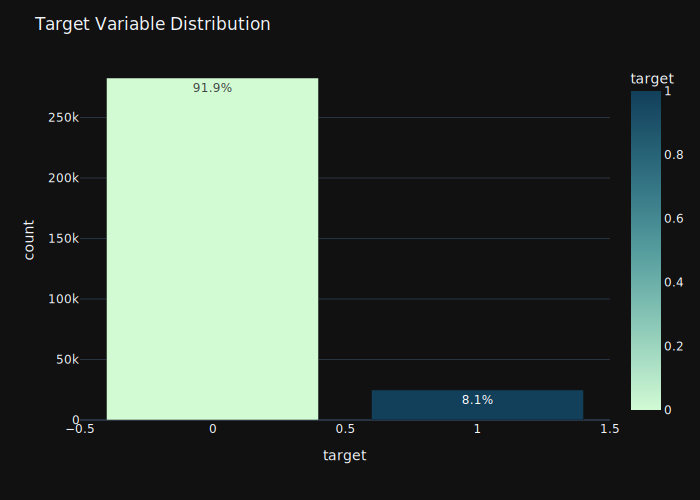

In [4]:
plot_histogram(
    application_train, "target", title="Target Variable Distribution", format="svg"
)

In [5]:
description: DataFrame = pl.read_csv(
    "HomeCredit_columns_description.csv", encoding="latin1"
)
description = lower_column_names(description)
description = lower_column_values(description)

# Delete training spaces for some entries in the row column
description = description.with_columns(
    pl.col("row").map_elements(lambda x: x.split(" ")[0], return_dtype=pl.String)
)

null_df = null_count_comparison(application_train, description, "amt_annuity")
null_df

table,feature,null_count
str,str,i64
"""bureau.csv""","""amt_annuity""",42
"""previous_application.csv""","""amt_annuity""",93
"""application_{train|test}.csv""","""amt_annuity""",12


### Null values 

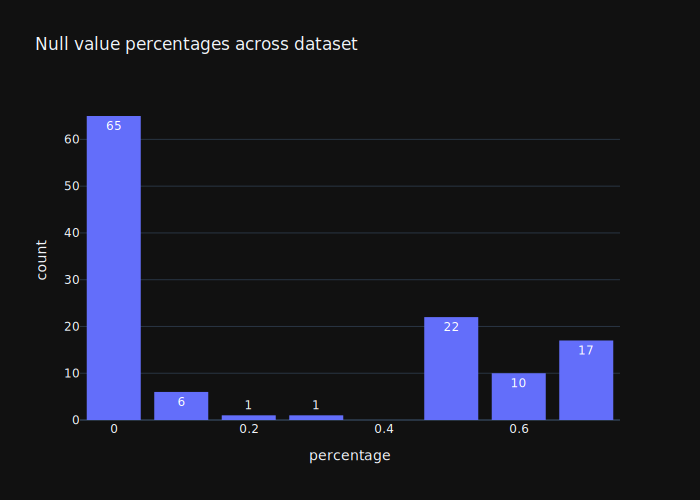

In [6]:
null_df = (
    application_train.null_count()
    .transpose(include_header=True)
    .rename(mapping={"column": "feature", "column_0": "null_count"})
    .sort(by="null_count", descending=True)
    .with_columns(
        pl.col("null_count")
        .map_elements(lambda x: x / len(application_train), return_dtype=pl.Float32)
        .alias("percentage")
    )
)

px.histogram(
    null_df,
    x="percentage",
    text_auto=True,
    title="Null value percentages across dataset",
).update_layout(bargap=0.2).show("svg")

The graph above shows that we have a pretty wide spread of null value prevalence within this dataset. Thankfully none of these null values are in the target variable, but we will have to make a choice in our analysis of how to treat null values within this dataset since some classifiers are more tolerant of null values than others. LightGBM and XGBoost can handle null values when fitting, but commonly used sklearn classifiers do not.

#### Look for categorical anomalies 

## Correlations 


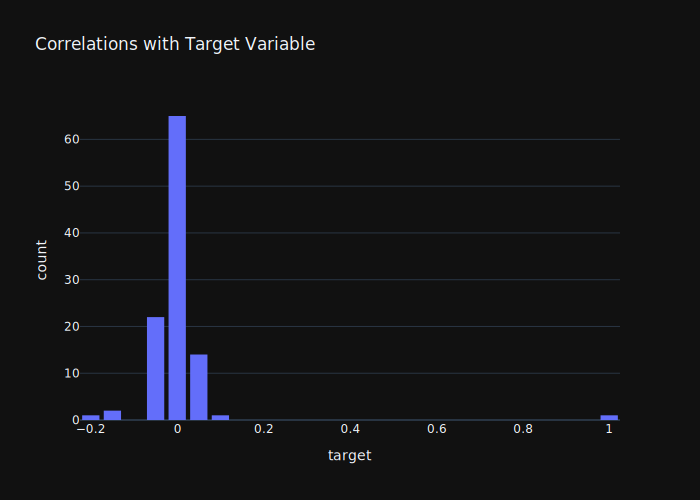

In [7]:
corr: DataFrame = (
    application_train.select(cs.by_dtype(pl.NUMERIC_DTYPES)).to_pandas().corr()
)
corr = pd.DataFrame(corr["target"])

px.histogram(corr, "target", title="Correlations with Target Variable").update_layout(
    bargap=0.2
).show("svg")

The graph above shows the distribution of correlations as a graphical distribution rather than in tabular form because we have so many variables that we're working with. None of our variables are correlated with target, save for target itself.

## Hypothesis testing

### Is there difference in proportions of clients that default when broken down by their region of residence? 
$H_0$: $p_1$ = $p_2$ = $p_3$<br>
$H_1$: $p_1$ $\neq$ $p_2$ $\neq$ $p_3$


In [8]:
region_default: DataFrame = pd.crosstab(
    application_train["region_rating_client"].to_pandas(),
    application_train["target"].to_pandas(),
    rownames=["region_rating_client"],
    colnames=["target"],
)
region_default["default_proportion"] = region_default.iloc[:, 1] / region_default.sum(
    axis=1
)
region_default["total"] = region_default.iloc[:, :-1].sum(axis=1)

# pooled sample proportion
p1_default_prop: float = region_default.default_proportion.iloc[0]
p2_default_prop: float = region_default.default_proportion.iloc[1]
p3_default_prop: float = region_default.default_proportion.iloc[2]

p1_population: float = region_default.total.iloc[0]
p2_population: float = region_default.total.iloc[1]
p3_population: float = region_default.total.iloc[2]

p: float = (
    p1_default_prop * p1_population
    + p2_default_prop * p2_population
    + p3_default_prop * p3_population
) / (p1_population + p2_population + p3_population)

# standard error
se: float = np.sqrt(
    (p * (1 - p)) * ((1 / p1_population) + (1 / p2_population) + (1 / p2_population))
)

# test statistic
z: float = (p1_default_prop - p2_default_prop - p3_default_prop) / se

if np.abs(z) < 1.64485:
    print(
        f"Fail to reject the null hypothesis. We can assume the default percentage to be the same across {'region_rating_client'}."
    )
else:
    print(
        f"z = {z:.3f}. Reject null hypothesis. The proportion of credit defaults across values of {'region_rating_client'} is not equal."
    )

z = -82.387. Reject null hypothesis. The proportion of credit defaults across values of region_rating_client is not equal.


Because both gender and region are not equal across their values when compared to our target variable, we they are more likely to have a significant relationship with default risk. We should include these variables in our predictor pool. This raises the question of what variables we should use to predict our models, given that we feasibly cannot include all of them. Let's move on to feature selection so we can restrict our feature set to one that is both significant and predictive of the target variable without being so onerous to run calculations on. 


### Are younger homeowners are more likely to default on credit payments? 

$H_0$: $\mu_d$ =  $\mu_n$<br>
$H_1$:  $\mu_d$ $\neq$ $\mu_n$

s.t. <br>
$\mu_d$: the average age of clients who default<br>
$\mu_n$: the average age of clients who do not default

In [9]:
age_df: DataFrame = application_train[["target", "days_birth"]]
age_df = age_df.with_columns((pl.col("days_birth") // -365)).rename(
    {"days_birth": "age"}
)

age_default: Series = age_df.filter(pl.col("target") == 1)["age"]
age_no_default: Series = age_df.filter(pl.col("target") == 0)["age"]

t_stat, p_value = stats.ttest_ind(age_no_default, age_default)

print("Two-sample t-test results:\n")
print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_value:.3f}\n")

if p_value < 0.05:
    print(
        "Reject the null hypothesis: there is a significant difference in the average ages \nof clients who default vs. those who don't.\n"
    )
else:
    print(
        "Fail to reject the null hypothesis: there is no significant difference in the average ages of clients who \ndefault vs. those who don't.\n"
    )

Two-sample t-test results:

t-statistic: 43.517
p-value: 0.000

Reject the null hypothesis: there is a significant difference in the average ages 
of clients who default vs. those who don't.



## Preparing data for modeling


Before we start creating models, it's important to lay out what our north star assessment criteria are for model assessment, and secondarily how we will choose what a high-performing model is. 

Given that our business problem is designing predictive classifiers of credit clients that are likely to default on payments, and that our training data is highly imbalanced such that our positive class is the minority class at a ratio of 10:1, we will need to be very precise in our metric selection. 

Therefore each model that we create will be judged on its ROC-AUC score, F1 score, Matthews Correlation Coefficient, Balanced Accuracy, Precision, and Recall. This sounds like a long list of metrics, so our primary determinants will be the ROC-AUC and MCC since ROC-AUC can be less powerful for highly imbalanced datasets, and MCC gives a pretty comprehensive view of a model's performance across all 4 quadrants of the confusion matrix.

## Modeling

Now that we've defined our metrics set and evaluation method, our workflow for the next section is as follows: 
1. Create pipelines to impute missing values, scale data, and fit to our classifier of choice
2. Calculate model statistics for each classifier



In [10]:
application_train: DataFrame = create_formatted_df("application_train.csv")

x: DataFrame = application_train.drop(["sk_id_curr", "target"]).to_pandas()
y: DataFrame = pl.DataFrame(application_train["target"]).to_pandas()

x_columns: list = x.columns

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=0, stratify=y
)

y_train: NDArray = np.array(y_train).ravel()

numerical_columns: list[str] = [
    *x.select_dtypes(exclude=["object", "category"]).columns
]

categorical_columns: list[str] = [
    *x.select_dtypes(include=["object", "category"]).columns
]

Now that we've defined the data that we'll be using for our modeling, we'll begin by taking a look at logistic regression.

In [11]:
model_performance = pd.DataFrame()
model_specifications = dict()


classifiers: list[str] = ["lgbm", "lgbm_rf", "xgboost"]

for classifier in classifiers:
    study = create_study(
        direction="maximize",
        study_name=(classifier + "\n"),
        pruner=SuccessiveHalvingPruner(reduction_factor=2),
        sampler=RandomSampler(seed=42),
    )

    study.optimize(
        lambda trial: objective(classifier, trial, x_train, np.array(y_train).ravel()),
        n_trials=num_trials,  # 4,
    )  # n_trials=100 is the original value

    model_specifications[classifier] = study.best_params

    best_trial: FrozenTrial = study.best_trial
    model: Pipeline = instantiate_model(
        classifier,
        trial=best_trial,
        numerical_columns=numerical_columns,
        categorical_columns=categorical_columns,
    )
    model.fit(x_train, y_train)
    predictions: NDArray = model.predict(x_test)
    model_performance[classifier] = calculate_model_statistics(y_test, predictions)
model_performance

,lgbm,lgbm_rf,xgboost
roc_auc,0.692187,0.672436,0.501202
matthews_correlation,0.225110,0.197224,0.007978
f_beta,0.518479,0.499662,0.009903
precision,0.170826,0.154258,0.107029
recall,0.669979,0.665145,0.008996
balanced_accuracy,0.692187,0.672436,0.501202


We're still not getting anywhere with these either, which means that our data could use a little more polishing before we feed them to models. One way to strengthen the models is with SMOTE oversampling, so we'll start there. 

## SMOTE Oversampling 
We'll use the combination of undersampling and oversampling originally put forth in the SMOTE paper to see how much that improves our model performance. We'll start by numerically encoding the categorical variables across application train before applying PCA and the conducting our under- and oversampling. 

In [12]:
numerical_train: DataFrame = application_train.clone()

# numerically encode features
encoder_mapping_key = dict()
for col in numerical_train.columns:
    try:
        key: dict[str, int] = create_encoder_mapping(numerical_train, col)
        numerical_train = encode_feature(numerical_train, col, key)
        encoder_mapping_key[col] = key
    except:
        pass


# fill missing values
for col in numerical_train.columns:
    median: float = numerical_train[col].median()
    numerical_train = numerical_train.with_columns(pl.col(col).fill_null(value=median))


x: DataFrame = numerical_train.drop("target").to_pandas()
y: Series = numerical_train[["target"]].to_pandas()

In [13]:
oversampling = SMOTE(sampling_strategy=0.1)
undersampling = RandomUnderSampler(sampling_strategy=0.5)

steps: list = [("oversample", oversampling), ("undersample", undersampling)]
pipeline = ImbPipeline(steps=steps)
smote_x, smote_y = pipeline.fit_resample(x, y)

pca = PCA(n_components=smote_x.shape[1])
smote_x: NDArray = pca.fit_transform(smote_x)

smote_x_train, smote_x_test, smote_y_train, smote_y_test = train_test_split(
    smote_x, smote_y, stratify=smote_y, random_state=15
)

smote_x_train = pd.DataFrame(smote_x_train, columns=x.columns)

smote_x_test = pd.DataFrame(smote_x_test, columns=x.columns)

Now that we've created our smote dataset, we can fit the models. However our previous model specifications aren't as helpful since the dataset is new, and models may perform better on different hyperparameters. Let's create another study and run it again! 

In [14]:
for idx, classifier in enumerate(["lgbm", "lgbm_rf", "xgboost"]):
    designator = "SMOTE_" + classifier

    study: Study = create_study(
        direction="maximize",
        study_name=(classifier + "\n"),
        pruner=SuccessiveHalvingPruner(reduction_factor=2),
        sampler=RandomSampler(seed=42),
    )
    study.optimize(
        lambda trial: objective(classifier, trial, smote_x_train, smote_y_train),
        n_trials=num_trials,
    )

    model_specifications[designator] = study.best_params

    if idx <= 1:
        smote_model = LGBMClassifier(**study.best_params, device="gpu")
    else:
        smote_model = XGBClassifier(
            **study.best_params,
            tree_method="gpu_hist",
            predictor="gpu_predictor",
            device="gpu",
        )
    smote_model.fit(smote_x_train, smote_y_train)
    predictions: NDArray = smote_model.predict(smote_x_test)

    model_performance[designator] = calculate_model_statistics(
        smote_y_test, predictions
    )
model_performance

,lgbm,lgbm_rf,xgboost,SMOTE_lgbm,SMOTE_lgbm_rf,SMOTE_xgboost
roc_auc,0.692187,0.672436,0.501202,0.653212,0.622294,0.599653
matthews_correlation,0.225110,0.197224,0.007978,0.291116,0.293828,0.256163
f_beta,0.518479,0.499662,0.009903,0.623062,0.369045,0.309109
precision,0.170826,0.154258,0.107029,0.488650,0.619201,0.609835
recall,0.669979,0.665145,0.008996,0.642706,0.353191,0.293052
balanced_accuracy,0.692187,0.672436,0.501202,0.653212,0.622294,0.599653


Based on trial runs that we have so far, we know that the lightgbm random forest models are the most performant of the ones that we've tried so far. The non-SMOTE models benefit from running through a higher number of trials, but there does seem to be an upper limit of about 0.69 in the roc_auc metric. Let's take a closer look at the false positive and false negative observations within the SMOTE random forest model to see if there are any patterns we could identify to boost model performance even further. 

In [17]:
params: dict = replicate_classifier_tuning(
    "lgbm_rf", x, y, study_name="lgbm_rf_v2", n_trials=1
)

lgbm_rf_v2_clf = LGBMClassifier(**params)
lgbm_rf_v2_clf.fit(smote_x_train, smote_y_train)
smote_predictions: NDArray = lgbm_rf_v2_clf.predict(smote_x_test)


calculate_model_statistics(smote_y_test, smote_predictions, title='SMOTE_lgbm')

,SMOTE_lgbm
roc_auc,0.581612
matthews_correlation,0.240764
f_beta,0.239966
precision,0.647467
recall,0.224282
balanced_accuracy,0.581612


Let's try alternative resampling techniques to see if that improves our model performances. 

### Adaptive Synthetic Sampling 

This sampling method focuses on hard-to-classify samples, generating synthetic data near the decision boundary, which may improve model performance. 

In [21]:
from imblearn.over_sampling import ADASYN
adasyn = ADASYN(sampling_strategy='minority', random_state=0)
ada_x, ada_y = adasyn.fit_resample(x, y)

ada_x_train, ada_x_test, ada_y_train, ada_y_test = train_test_split(
    ada_x, ada_y, stratify=ada_y, random_state=15
)

In [26]:
for idx, classifier in enumerate(["lgbm", "lgbm_rf", "xgboost"]):
    designator = "AdaSyn_" + classifier

    study: Study = create_study(
        direction="maximize",
        study_name=(classifier + "\n"),
        pruner=SuccessiveHalvingPruner(reduction_factor=2),
        sampler=RandomSampler(seed=42),
    )
    study.optimize(
        lambda trial: objective(classifier, trial, ada_x_train, ada_y_train),
        n_trials=num_trials,
    )

    model_specifications[designator] = study.best_params

    if idx <= 1:
        ada_model = LGBMClassifier(**study.best_params, device="gpu")
    else:
        ada_model = XGBClassifier(
            **study.best_params,
            tree_method="gpu_hist",
            predictor="gpu_predictor",
            device="gpu",
        )
    ada_model.fit(ada_x_train, ada_y_train)
    predictions: NDArray = ada_model.predict(ada_x_test)

    model_performance[designator] = calculate_model_statistics(
        ada_y_test, predictions
    )
model_performance

,lgbm,lgbm_rf,xgboost,SMOTE_lgbm,SMOTE_lgbm_rf,SMOTE_xgboost,AdaSynlgbm,AdaSynlgbm_rf,AdaSynxgboost,AdaSyn_lgbm,AdaSyn_lgbm_rf,AdaSyn_xgboost
roc_auc,0.692187,0.672436,0.501202,0.653212,0.622294,0.599653,0.956217,0.956293,0.665229,0.956217,0.956293,0.664634
matthews_correlation,0.225110,0.197224,0.007978,0.291116,0.293828,0.256163,0.915196,0.915332,0.331880,0.915196,0.915332,0.330579
f_beta,0.518479,0.499662,0.009903,0.623062,0.369045,0.309109,0.921054,0.921228,0.704344,0.921054,0.921228,0.702257
precision,0.170826,0.154258,0.107029,0.488650,0.619201,0.609835,0.999270,0.999224,0.655592,0.999270,0.999224,0.655535
recall,0.669979,0.665145,0.008996,0.642706,0.353191,0.293052,0.913112,0.913307,0.710212,0.913112,0.913307,0.707863
balanced_accuracy,0.692187,0.672436,0.501202,0.653212,0.622294,0.599653,0.956217,0.956293,0.665229,0.956217,0.956293,0.664634


In [44]:
rf_params= model_specifications['AdaSynlgbm_rf']

In [34]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, stratify=y, random_state=15
)


params: dict = replicate_classifier_tuning(
    "lgbm_rf", x, y, study_name="AdaSynlgbm_rf", n_trials=1
)

ada_rf = LGBMClassifier(**params)
ada_rf.fit(x_train, y_train)
smote_predictions: NDArray = ada_rf.predict(x_test)


calculate_model_statistics(y_test, smote_predictions, title='Adsyn_rf')

,Adsyn_rf
roc_auc,0.500623
matthews_correlation,0.028392
f_beta,0.001432
precision,0.727273
recall,0.001289
balanced_accuracy,0.500623


In [42]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

In [68]:
# Preprocessing steps for numerical and categorical features
numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy=rf_params['numerical_strategy'], fill_value=0)),
        ('scaler', StandardScaler() if rf_params['with_scaling'] else None)
    ])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy=rf_params['categorical_strategy'], fill_value=-1)),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Create a ColumnTransformer that applies different transformations for numerical and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
            ('num', numerical_transformer, numerical_columns),
            ('cat', categorical_transformer, categorical_columns)
        ])

lgbm_params=dict(zip(list(rf_params.keys())[7:], list(rf_params.values())[7:])) # isolate lgbm params

ada_rf=LGBMClassifier(**lgbm_params, boosting_type='rf')
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

pipeline.fit(x_train, y_train)

# Evaluate the model
y_pred = pipeline.predict(x_test)

ValueError: Specifying the columns using strings is only supported for dataframes.

In [16]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Code for later

### False Positive and False Negative analysis


In [ ]:
smote_y_test.unique()


Let's first start by first merging smote test set, along with the actual and predicted labels 

In [ ]:
prediction_df = pd.DataFrame(smote_x_test, columns=x.columns)
prediction_df["y_actual"] = smote_y_test
prediction_df["y_predicted"] = smote_predictions
prediction_df

In [ ]:
#initialize empty column
prediction_df['cm_quadrant']=''

prediction_df[['y_actual','y_predicted', 'cm_quadrant']].sample(5)

Now that we have this dataframe assembled, let's mark the observations within it based on the quadrant of the confusion matrix that they correspond to. 

In [ ]:
tp_index = prediction_df[(prediction_df.y_predicted == 1) & (prediction_df.y_actual == 1)].index
tn_index = prediction_df[(prediction_df.y_predicted == 0) & (prediction_df.y_actual == 0)].index
fn_index = prediction_df[(prediction_df.y_predicted == 0) & (prediction_df.y_actual == 1)].index
fp_index = prediction_df[(prediction_df.y_predicted == 1) & (prediction_df.y_actual == 0)].index

In [ ]:
prediction_df['cm_quadrant'].iloc[tp_index]='tp'
prediction_df['cm_quadrant'].iloc[tn_index]='tn'
prediction_df['cm_quadrant'].iloc[fp_index]='fp'
prediction_df['cm_quadrant'].iloc[fn_index]='fn'

In [ ]:
prediction_df[prediction_df.cm_quadrant==''].shape